# Семинар 12. Обучение без учителя

Подключение библиотек. 
$
\newcommand{\R}{\mathbb{R}}
\newcommand{\X}{\mathbb{X}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\E}{\mathbb{E}}
\newcommand{\D}{\mathbb{D}}
\renewcommand{\Prob}{\mathbb{P}}
\renewcommand{\le}{\leqslant}
\renewcommand{\ge}{\geqslant}
\newcommand{\eps}{\varepsilon}
\newcommand{\Normal}{\mathcal{N}}
\DeclareMathOperator{\TP}{TP}
\DeclareMathOperator{\FP}{FP}
\DeclareMathOperator{\TN}{TN}
\DeclareMathOperator{\FN}{FN}
\DeclareMathOperator{\Accuracy}{Accuracy}
\DeclareMathOperator{\Precision}{Precision}
\DeclareMathOperator{\Recall}{Recall}
\DeclareMathOperator{\Fscore}{F_1}
\DeclareMathOperator{\MSE}{MSE}
\DeclareMathOperator{\RMSE}{RMSE}
\DeclareMathOperator{\MAE}{MAE}
\DeclareMathOperator{\MAPE}{MAPE}
\DeclareMathOperator{\Rsqured}{R^2}
$

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wg

from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

cm = ListedColormap(['red', 'blue', 'green', 'purple', 'orange', 'brown', 'gray', 'black', 'cyan', 'magenta'])
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
from sklearn import set_config

set_config(display='diagram')

In [3]:
from tqdm.auto import tqdm
from tensorflow.keras.callbacks import Callback


class ProgressCallback(Callback):
    def __init__(self, epochs):
        self.pbar = tqdm(total=epochs)

    def on_epoch_end(self, epoch, logs):
        if epoch % 16 == 0 or epoch >= self.pbar.total - 1:
            self.pbar.update(max(0, epoch - self.pbar.n))
            self.pbar.refresh()

# 1. Кластеризация

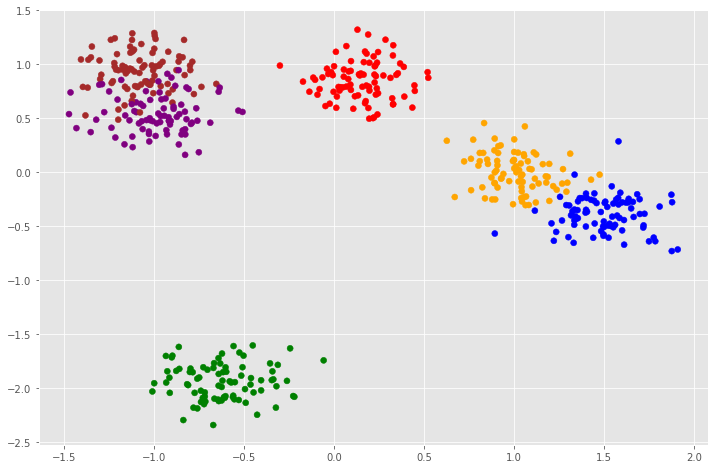

In [4]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


N = 512
K = 6

np.random.seed(42)
X, y = make_blobs(n_samples=N, 
                  n_features=2,
                  centers=K,
                  random_state=42)
X = StandardScaler().fit_transform(X)

plt.scatter(X[:, 0], X[:, 1], c=cm(y), label='Data')
plt.show()

# 1.1. K-средних


* Выбирается $k$ центров.
* Все наблюдения относятся в кластер с ближайшим центром.
* Центры пересчитываются.
* Итерируемся до сходимости.

In [5]:
from scipy.stats import mode


def plot_cluster(X, y_true, model, true_colors=False, title=''):
    y_pred = model.fit_predict(X)
    _, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 7))
    for v in sorted(np.unique(y_pred)):
        idx = (y_pred == v)
        if true_colors:
            color = mode(y_true[idx]).mode
        else:
            color = v
            
        color = cm(color) if color <= 10 else None
        
        if v < 0:
            ax1.scatter(X[idx, 0], X[idx, 1], facecolor=(0, 0, 0, 0), edgecolors='black', label='No class')
        else:
            ax1.scatter(X[idx, 0], X[idx, 1], color=color, label=f'class {v}')
    
    ax2.scatter(X[:, 0], X[:, 1], c=cm(y_true))
    ax1.legend()
    ax1.set_title(title)
    plt.show()

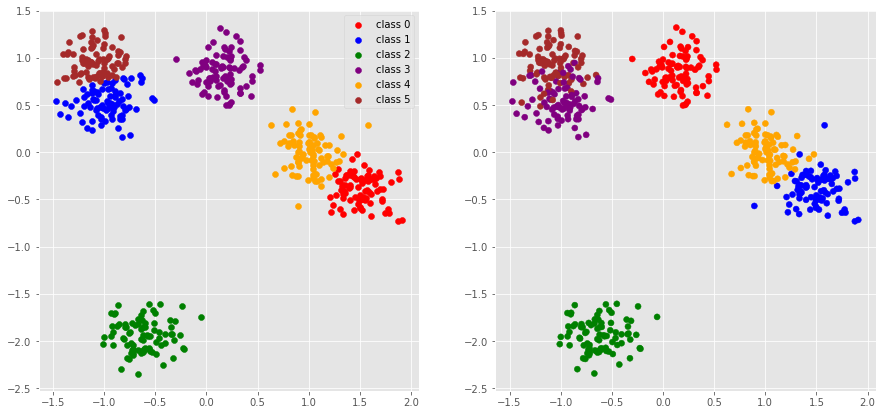

In [6]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=K, random_state=42)
plot_cluster(X, y, kmeans)

Оптимальное число классов:

In [7]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import silhouette_score, make_scorer


silhouette = make_scorer(silhouette_score)
gs = GridSearchCV(kmeans, {
    'n_clusters': np.arange(2, 12),
}, cv=KFold(10, random_state=42, shuffle=True), scoring=silhouette)
gs.fit(X, X)
gs.best_estimator_

KMeans(n_clusters=4, random_state=42)

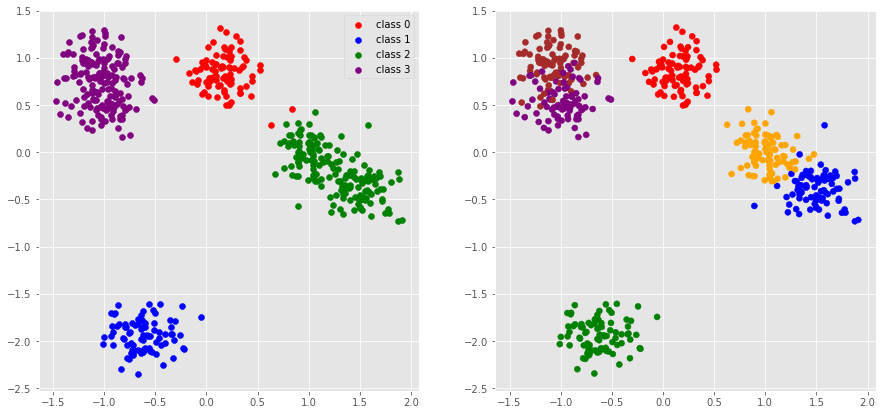

In [8]:
plot_cluster(X, y, gs.best_estimator_)

# 1.2. Иерархическая кластеризация


* Начинаем с кластеров N (каждое наблюдение -- кластер).
* Кластеры последовательно объединяются.


Методы связей:
* __Ward__ минимизирует сумму квадратов отклонений по всем кластерам.
* __Maximum__ или __complete__ минимизирует максимальное расстояние между наблюдениями в паре кластеров.
* __Average__ минимизирует среднее расстояние между всеми наблюдениями в паре кластеров.
* __Single__ минимизирует расстояние между ближайшими наблюдениями в паре кластеров.

In [11]:
# from sklearn.metrics.pairwise import ...

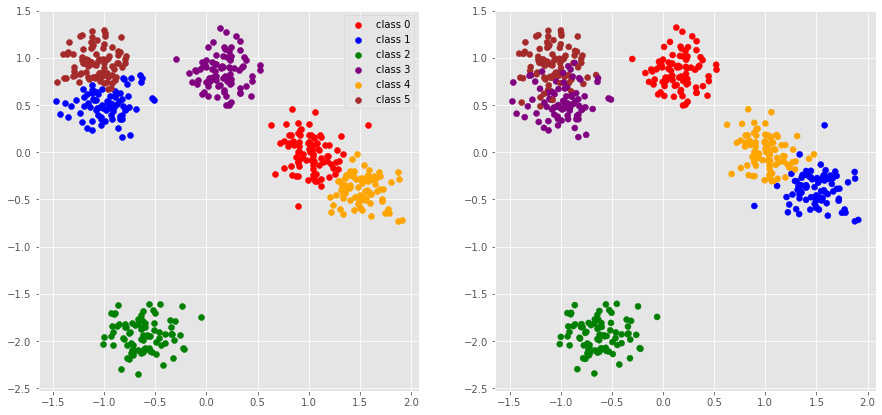

In [9]:
from sklearn.cluster import AgglomerativeClustering


agglomerative = AgglomerativeClustering(n_clusters=K, linkage='ward')
plot_cluster(X, y, agglomerative)

Отбираем оптимальные параметры:

In [12]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import davies_bouldin_score


score_func = lambda X, true, pred: silhouette_score(X, pred)
# score_func = lambda X, true, pred: -davies_bouldin_score(X, pred)

score_list = []
param_grid = ParameterGrid({
    'n_clusters': np.arange(2, 16), 
    'linkage': ('ward', 'single', 'complete', 'average')
})
for param in param_grid:
    agglomerative = AgglomerativeClustering(**param)
    score = []
    for train_index, _ in KFold(10, random_state=42, shuffle=True).split(X):
        Xt = X[train_index]
        yt = y[train_index]
        yt_pred = agglomerative.fit_predict(Xt)
        score.append(score_func(Xt, yt, yt_pred))
    score_list.append(np.mean(score))
    
best_params_ = np.argmax(score_list)
best_params_ = param_grid[best_params_]

best_params_

{'n_clusters': 4, 'linkage': 'ward'}

In [18]:
def func(x, y, z, *args, **kwargs):
    print('x:', x)
    print('y:', y)
    print('z:', z)
    print('args:', args)
    print('kwargs:', kwargs)
    
    
params = {
    'x': 10,
    'y': 20,
    'z': 'hello',
    'test': 'works'
}

func(**params)
print('=' * 80)
func(10, 20, 'hello', 'test')

x: 10
y: 20
z: hello
args: ()
kwargs: {'test': 'works'}
x: 10
y: 20
z: hello
args: ('test',)
kwargs: {}


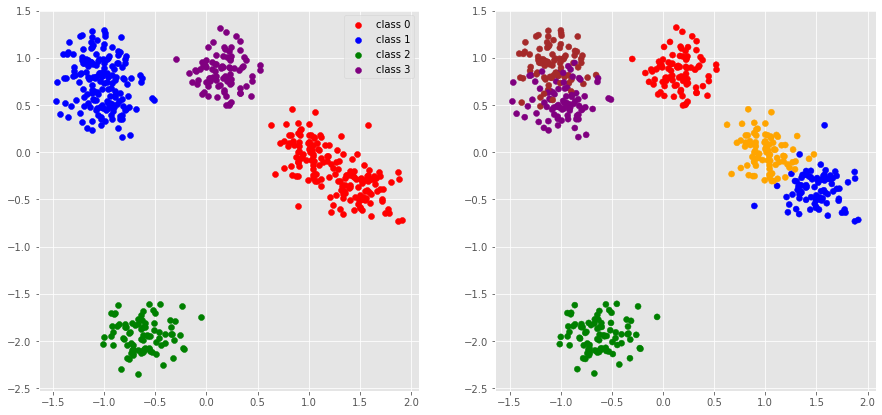

In [13]:
agglomerative = AgglomerativeClustering(**best_params_)

plot_cluster(X, y, agglomerative, true_colors=False)

Подробности о работе методов кластеризации можно найти в [документации](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering).

# 1.3. DBSCAN

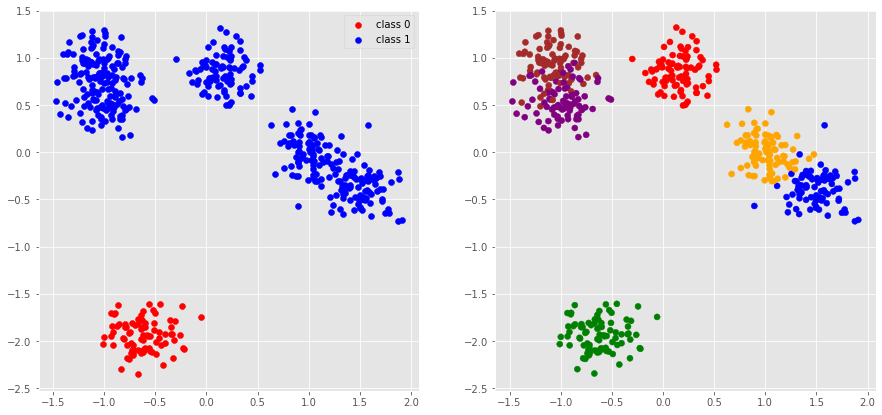

In [20]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=0.5)
plot_cluster(X, y, dbscan)

In [25]:
score_func = lambda X, true, pred: silhouette_score(X, pred)
score_func = lambda X, true, pred: davies_bouldin_score(X, pred)


score_list = []
param_grid = ParameterGrid({
    'eps': np.arange(0.1, 2.1, 0.1)
})
for param in param_grid:
    dbscan = DBSCAN(**param)
    score = []
    for train_index, _ in KFold(10, random_state=42, shuffle=True).split(X):
        Xt = X[train_index]
        yt = y[train_index]
        yt_pred = dbscan.fit_predict(Xt)
        if np.unique(yt_pred).shape[0] > 1:
            score.append(score_func(Xt, yt, yt_pred))
    score = np.mean(score) if score else [-1]
    score_list.append(np.mean(score))
    
best_params_ = np.argmax(score_list)
best_params_ = param_grid[best_params_]

best_params_

{'eps': 0.1}

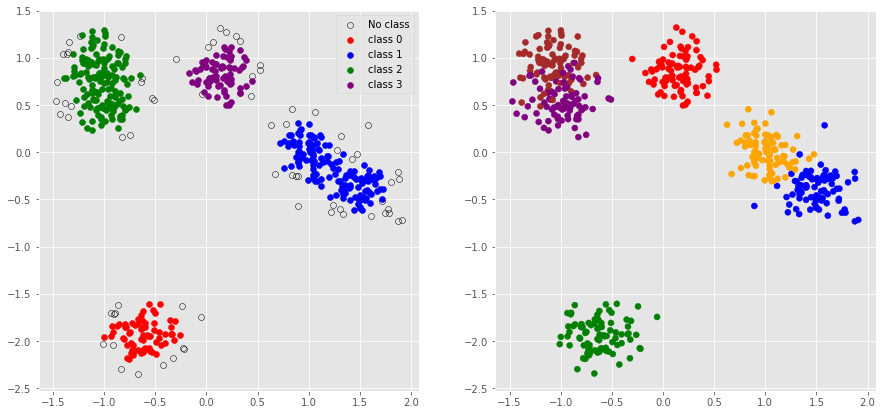

In [26]:
dbscan = DBSCAN(**best_params_)
plot_cluster(X, y, dbscan)

# 1.4. Демо

In [27]:
from sklearn.datasets import make_moons, make_circles


datasets = {
    'blobs': (X, y),
    'moons': make_moons(n_samples=N,
                        shuffle=True,
                        noise=0.1,
                        random_state=42),
    'circles': make_circles(n_samples=256, 
                            shuffle=True,
                            noise=0.07, factor=0.5,
                            random_state=42)
}

In [33]:
out = wg.Output()

def func(dataset, n_clusters):
    X, y = datasets[dataset]
    with out:
        out.clear_output(wait=True)
        kmeans = KMeans(
            n_clusters=n_clusters,
        )
        metric = silhouette_score(X, kmeans.fit_predict(X))
        plot_cluster(X, y, kmeans, title=f'{kmeans}\n{metric}')


wg.interact(func,
            dataset=wg.SelectionSlider(options=['blobs', 'moons', 'circles']),
            n_clusters=wg.IntSlider(min=2, max=16, value=K))
display(out)

interactive(children=(SelectionSlider(description='dataset', options=('blobs', 'moons', 'circles'), value='blo…

Output()

In [32]:
out = wg.Output()

def func(dataset, n_clusters, linkage):
    X, y = datasets[dataset]
    with out:
        out.clear_output(wait=True)
        agglomerative = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage=linkage,
        )
        metric = silhouette_score(X, agglomerative.fit_predict(X))
        plot_cluster(X, y, agglomerative, title=f'{agglomerative}\n{metric}')


wg.interact(func,
            dataset=wg.SelectionSlider(options=['blobs', 'moons', 'circles']),
            n_clusters=wg.IntSlider(min=2, max=16, value=5),
            linkage=wg.SelectionSlider(options=['ward', 'complete', 'average', 'single']))
display(out)

interactive(children=(SelectionSlider(description='dataset', options=('blobs', 'moons', 'circles'), value='blo…

Output()

In [30]:
out = wg.Output()

def func(dataset, eps, min_samples):
    X, y = datasets[dataset]
    with out:
        out.clear_output(wait=True)
        dbscan = DBSCAN(
            eps=eps,
            min_samples=min_samples,
        )
        plot_cluster(X, y, dbscan, title=f'{dbscan}')


wg.interact(func,
            dataset=wg.SelectionSlider(options=['blobs', 'moons', 'circles']),
            eps=wg.FloatSlider(min=0.01, max=2.0, step=0.01),
            min_samples=wg.IntSlider(min=1, max=20, value=5))
display(out)

interactive(children=(SelectionSlider(description='dataset', options=('blobs', 'moons', 'circles'), value='blo…

Output()

# 2. Автокодировщик

In [34]:
from tensorflow.keras.layers import Dense, ReLU, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [35]:
from sklearn.datasets import load_digits


X, y = load_digits(return_X_y=True)

X /= 16

In [37]:
X.shape

(1797, 64)

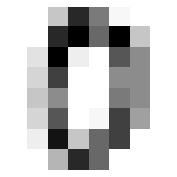

In [39]:
def show_image(img, ax=None):
    img = img.reshape(8, 8)

    if ax is None:
        plt.figure(0, (3, 3))
        plt.imshow(img, cmap='Greys')
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(img, cmap='Greys')
        ax.set_axis_off()
        
show_image(X[0])

In [40]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy

In [41]:
n_hidden = 2

encoder = Sequential([
    BatchNormalization(momentum=0.999),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(n_hidden),
    BatchNormalization(momentum=0.999)
])
decoder = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='sigmoid')
])

model = Sequential([
    encoder, 
    decoder
])
optimizer = Adam(learning_rate=1e-2)
model.compile(optimizer, loss='binary_crossentropy')

epochs = 512
batch_size = 128
fit_history = model.fit(X, X, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=0, 
          validation_split=0.1,
          callbacks=[
              ProgressCallback(epochs),
              LearningRateScheduler(lambda epoch, lr: lr / 10 if epoch in {128,} else lr)
          ])
model.summary()

  0%|          | 0/512 [00:00<?, ?it/s]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 50058     
_________________________________________________________________
sequential_1 (Sequential)    (None, 64)                49856     
Total params: 99,914
Trainable params: 99,782
Non-trainable params: 132
_________________________________________________________________


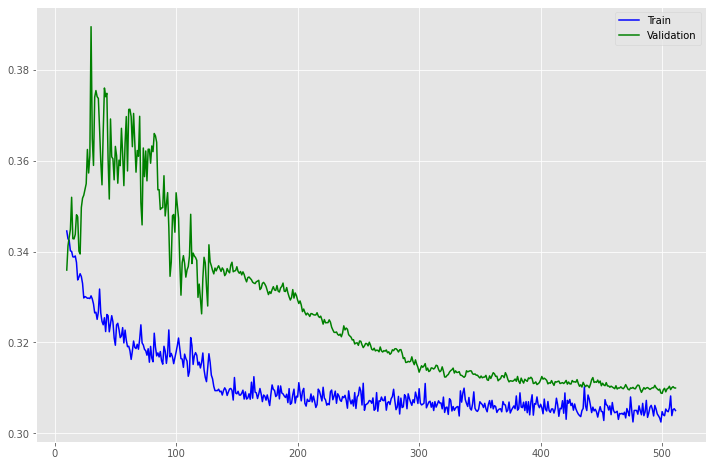

In [42]:
idx = np.arange(epochs)
start = 10

plt.plot(idx[start:], fit_history.history['loss'][start:], label='Train', color='blue')
plt.plot(idx[start:], fit_history.history['val_loss'][start:], label='Validation', color='green')

plt.legend()
plt.show()

In [43]:
def plot_digits(X, y, ax=None):
    show = False
    if ax is None:
        plt.figure(0, (12, 8))
        ax = plt.gca()
        show = True
    for i in range(10):
        Xl = X[y == i]
        ax.scatter(Xl[:, 0], Xl[:, 1], marker=f'${i}$')
    if show:
        plt.show()

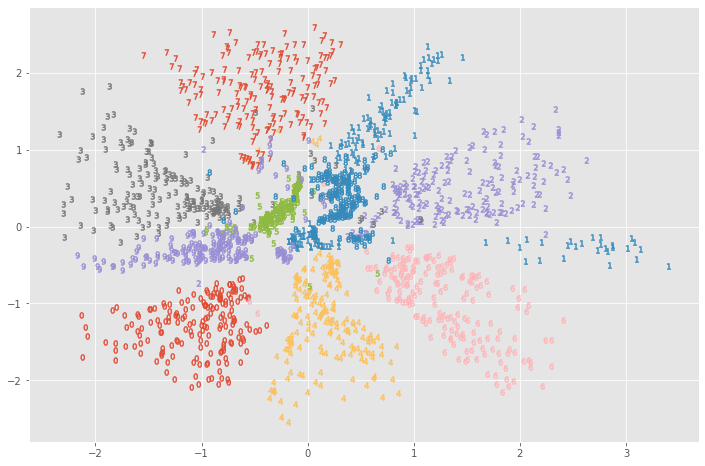

In [44]:
E, D = model.layers

Xt = E.predict(X)
plot_digits(Xt, y)

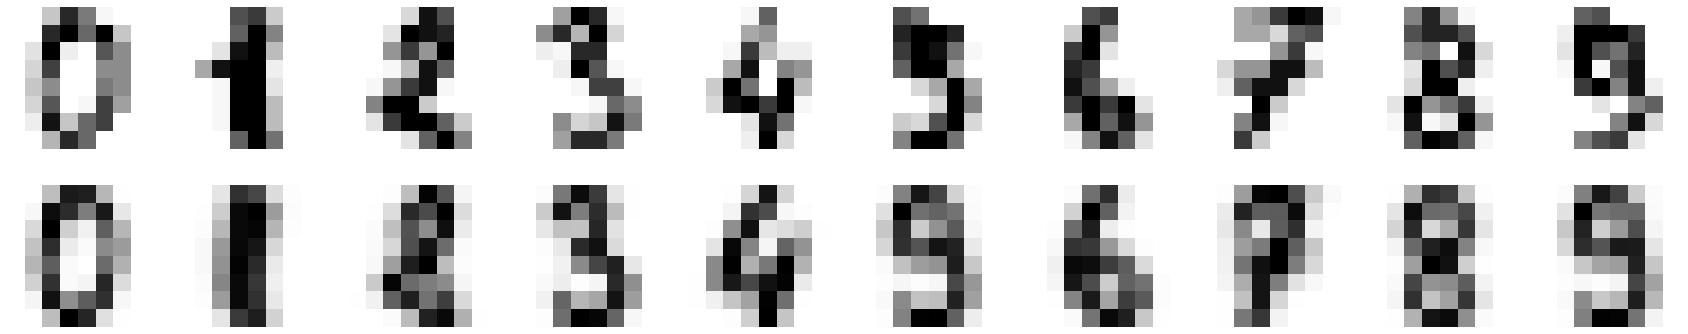

In [46]:
Xr = D.predict(Xt)
# Xr = model.predict(X)

N_plots = 10
_, axes = plt.subplots(2, 10, figsize=(3 * N_plots, 6))

for img, img_rec, ax in zip(X, Xr, axes.T):
    show_image(img, ax[0])
    show_image(img_rec, ax[1])

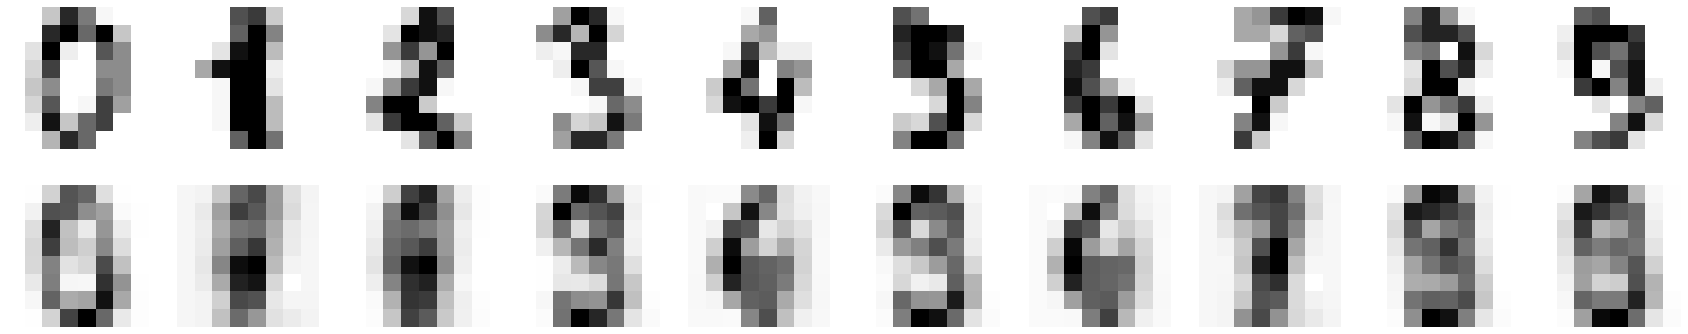

In [47]:
from sklearn.decomposition import PCA


n_components = 2
pca = PCA(n_components).fit(X)
Xt_pca = pca.transform(X)
Xr_pca = pca.inverse_transform(Xt_pca)


N_plots = 10
_, axes = plt.subplots(2, 10, figsize=(3 * N_plots, 6))

for img, img_rec, ax in zip(X, Xr_pca, axes.T):
    show_image(img, ax[0])
    show_image(img_rec, ax[1])

Демонстрация:

In [49]:
import ipywidgets as wg


out = wg.Output()

def func(x1, x2):
    x = np.array([[x1, x2]])
    img_autoencoder = D.predict(x)
    img_pca = pca.inverse_transform(x)
    
    with out:
        _, [ax1, ax2] = plt.subplots(2, 2, figsize=(15, 12), gridspec_kw={'width_ratios':[5, 1]})
        plot_digits(Xt, y, ax1[0])
        plot_digits(Xt_pca, y, ax2[0])
        show_image(img_autoencoder, ax1[1])
        show_image(img_pca, ax2[1])
        
        ax1[0].scatter(x[:, 0], x[:, 1], s=30, color='black')
        ax2[0].scatter(x[:, 0], x[:, 1], s=30, color='black')
    return

wg.interact(func,
    x1=wg.FloatSlider(min=-4, max=4, value=0, step=0.1),
    x2=wg.FloatSlider(min=-4, max=4, value=0, step=0.1),)
display(out)

interactive(children=(FloatSlider(value=0.0, description='x1', max=4.0, min=-4.0), FloatSlider(value=0.0, desc…

Output()

# 3. LDA

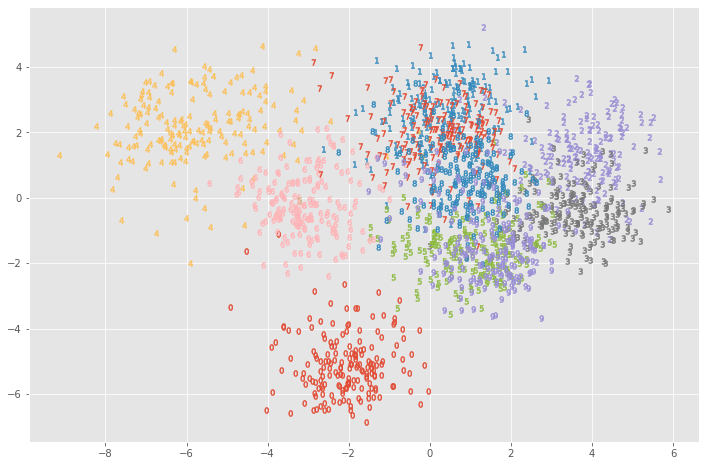

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

plot_digits(lda.transform(X), y)

In [51]:
gs = GridSearchCV(lda, {
    'n_components': np.arange(2, 10),
})
gs.fit(X, y)
gs.best_estimator_

LinearDiscriminantAnalysis(n_components=2)

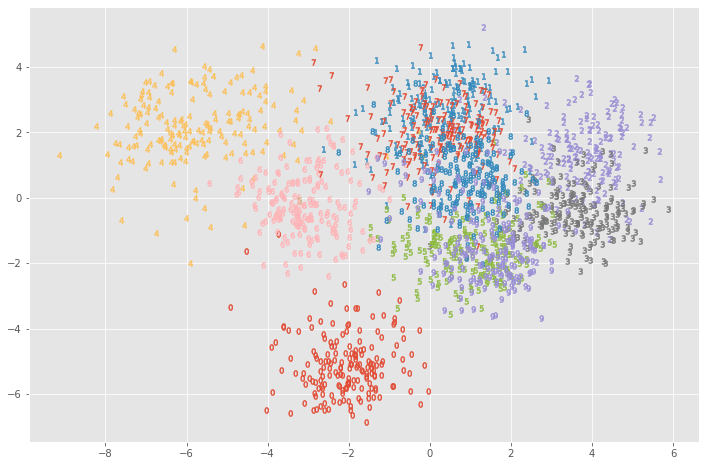

In [52]:
plot_digits(gs.transform(X), y)